In [1]:
pip install ta

  Created wheel for ta: filename=ta-0.7.0-py3-none-any.whl size=28721 sha256=a7570a9aa65af19b1b5107f19ff6e73584ce3f4fec24dfbc40670227b121970c
  Stored in directory: c:\users\jimmy\appdata\local\pip\cache\wheels\bb\7c\a0\9c72e50ddef1f7c3d9003bf4ccc5d5c8deb24828d4eb156fc8
Successfully built ta
Note: you may need to restart the kernel to use updated packages.


In [ ]:
conda install -c quantopian ta-lib


Examining python=3.8:  75%|#######5  | 3/4 [00:00<00:00, 33.39it/s]
                                                                   

Examining conflict for ta-lib python:   0%|          | 0/4 [00:00<?, ?it/s]
                                                                           

UnsatisfiableError: The following specifications were found
to be incompatible with the existing python installation in your environment:

Specifications:

  - ta-lib -> python[version='2.7.*|3.4.*|>=3.5,<3.6.0a0|>=3.6,<3.7.0a0|3.5.*']

Your python: python=3.8

If python is on the left-most side of the chain, that's the version you've asked for.
When python appears to the right, that indicates that the thing on the left is somehow
not available for the python version you are constrained to. Note that conda will not
change your python version to a different minor version unless you explicitly specify
that.





Solving environment: ...working... failed with initial frozen solve. Retrying with flexible solve.
Solving environment: ...working... failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: ...working... failed with initial frozen solve. Retrying with flexible solve.
Solving environment: ...working... 
Found conflicts! Looking for incompatible packages.
This can take several minutes.  Press CTRL-C to abort.
failed


In [3]:
pip install yfinance

  Created wheel for yfinance: filename=yfinance-0.1.59-py2.py3-none-any.whl size=23447 sha256=117491ce23ae307cf232ebed479821f36f57a61843cf0c27f82d312e5a662e5f
  Stored in directory: c:\users\jimmy\appdata\local\pip\cache\wheels\7e\d5\f4\f628965651f61ae35c2bdc73571ce1a2026e1550a336b5ad4b
  Created wheel for multitasking: filename=multitasking-0.0.9-py3-none-any.whl size=8372 sha256=4c6bcfb7acce2cb1c273683c016ad15c4070591af2ade3523ab551c092c99276
  Stored in directory: c:\users\jimmy\appdata\local\pip\cache\wheels\57\6d\a3\a39b839cc75274d2acfb1c58bfead2f726c6577fe8c4723f13
Successfully built yfinance multitasking
Note: you may need to restart the kernel to use updated packages.


In [71]:
import pandas_datareader.data as web
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import talib as ta
from ta.momentum import RSIIndicator
from ta.trend import MACD
from ta.volatility import BollingerBands
import yfinance as yf


In [32]:
class Company:
    def __init__(self, symbol):
        self.symbol = symbol
        self.technical_indicators = None
        self.prices = None


def generate_buy_sell_signals(condition_buy, condition_sell, dataframe, strategy):
    last_signal = None
    indicators = []
    buy = []
    sell = []
    for i in range(0, len(dataframe)):
        # if buy condition is true and last signal was not Buy
        if condition_buy(i, dataframe) and last_signal != 'Buy':
            last_signal = 'Buy'
            indicators.append(last_signal)
            buy.append(dataframe['Close'].iloc[i])
            sell.append(np.nan)
        # if sell condition is true and last signal was Buy
        elif condition_sell(i, dataframe)  and last_signal == 'Buy':
            last_signal = 'Sell'
            indicators.append(last_signal)
            buy.append(np.nan)
            sell.append(dataframe['Close'].iloc[i])
        else:
            indicators.append(last_signal)
            buy.append(np.nan)
            sell.append(np.nan)

    dataframe[f'{strategy}_Last_Signal'] = np.array(last_signal)
    dataframe[f'{strategy}_Indicator'] = np.array(indicators)
    dataframe[f'{strategy}_Buy'] = np.array(buy)
    dataframe[f'{strategy}_Sell'] = np.array(sell)


In [48]:
def set_technical_indicators(config, company):
    company.technical_indicators = pd.DataFrame()
    company.technical_indicators['Close'] = company.prices

    get_macd(config, company)
    get_rsi(config, company)
    get_bollinger_bands(config, company)


def get_macd(config, company):
    close_prices = company.prices
    dataframe = company.technical_indicators
    window_slow = 26
    signal = 9
    window_fast = 12
    macd = MACD(company.prices, window_slow, window_fast, signal)
    dataframe['MACD'] = macd.macd()
    dataframe['MACD_Histogram'] = macd.macd_diff()
    dataframe['MACD_Signal'] = macd.macd_signal()

    generate_buy_sell_signals(
        lambda x, dataframe: dataframe['MACD'].values[x] < dataframe['MACD_Signal'].iloc[x],
        lambda x, dataframe: dataframe['MACD'].values[x] > dataframe['MACD_Signal'].iloc[x],
        dataframe,
        'MACD')
    return dataframe


def get_rsi(config, company):
    close_prices = company.prices
    dataframe = company.technical_indicators
    rsi_time_period = 20

    rsi_indicator = RSIIndicator(close_prices, rsi_time_period)
    dataframe['RSI'] = rsi_indicator.rsi()

    low_rsi = 40
    high_rsi = 70

    generate_buy_sell_signals(
        lambda x, dataframe: dataframe['RSI'].values[x] < low_rsi,
        lambda x, dataframe: dataframe['RSI'].values[x] > high_rsi,
    dataframe, 'RSI')

    return dataframe


def get_bollinger_bands(config, company):

    close_prices = company.prices
    dataframe = company.technical_indicators

    window = 20

    indicator_bb = BollingerBands(close=close_prices, window=window, window_dev=2)

    # Add Bollinger Bands features
    dataframe['Bollinger_Bands_Middle'] = indicator_bb.bollinger_mavg()
    dataframe['Bollinger_Bands_Upper'] = indicator_bb.bollinger_hband()
    dataframe['Bollinger_Bands_Lower'] = indicator_bb.bollinger_lband()

    generate_buy_sell_signals(
        lambda x, signal: signal['Close'].values[x] < signal['Bollinger_Bands_Lower'].values[x],
        lambda x, signal: signal['Close'].values[x] > signal['Bollinger_Bands_Upper'].values[x],
        dataframe, 'Bollinger_Bands')

    return dataframe

set_technical_indicators


In [73]:
import os

from matplotlib import pyplot as plt
import numpy as np

class TechnicalIndicatorsChartPlotter:
    def plot_price_and_signals(self, fig, company, data, strategy, axs):
        last_signal_val = data[f'{strategy}_Last_Signal'].values[-1]
        last_signal = 'Unknown' if not last_signal_val else last_signal_val
        title = f'Close Price Buy/Sell Signals using {strategy}.  Last Signal: {last_signal}'
        fig.suptitle(f'Top: {company.symbol} Stock Price. Bottom: {strategy}')

        if not data[f'{strategy}_Buy'].isnull().all():
            axs[0].scatter(data.index, data[f'{strategy}_Buy'], color='green', label='Buy Signal', marker='^', alpha=1)
        if not data[f'{strategy}_Sell'].isnull().all():
            axs[0].scatter(data.index, data[f'{strategy}_Sell'], color='red', label='Sell Signal', marker='v', alpha=1)
        axs[0].plot(company.prices, label='Close Price', color='blue', alpha=0.35)

        plt.xticks(rotation=45)
        axs[0].set_title(title)
        axs[0].set_xlabel('Date', fontsize=18)
        axs[0].set_ylabel('Close Price', fontsize=18)
        axs[0].legend(loc='upper left')
        axs[0].grid()

    def plot_macd(self, company):
        image = f'images/{company.symbol}_macd.png'
        macd = company.technical_indicators

        # Create and plot the graph
        fig, axs = plt.subplots(2, sharex=True, figsize=(13,9))
        self.plot_price_and_signals(fig, company, macd, 'MACD', axs)

        axs[1].plot(macd['MACD'], label=company.symbol+' MACD', color = 'green')
        axs[1].plot(macd['MACD_Signal'], label='Signal Line', color='orange')
        positive = macd['MACD_Histogram'][(macd['MACD_Histogram'] >= 0)]
        negative = macd['MACD_Histogram'][(macd['MACD_Histogram'] < 0)]
        axs[1].bar(positive.index, positive, color='green')
        axs[1].bar(negative.index, negative, color='red')    
        axs[1].legend(loc='upper left')
        axs[1].grid()
        print(os.path.abspath(image))
        plt.show()

    def plot_rsi(self, company):
        image = f'images/{company.symbol}_rsi.png'
        rsi = company.technical_indicators
        low_rsi = 40
        high_rsi = 70

        #plt.style.use('default')
        fig, axs = plt.subplots(2, sharex=True, figsize=(13, 9))
        self.plot_price_and_signals(fig, company, rsi, 'RSI', axs)
        axs[1].fill_between(rsi.index, y1=low_rsi, y2=high_rsi, color='#adccff', alpha=0.3)
        axs[1].plot(rsi['RSI'], label='RSI', color='blue', alpha=0.35)
        axs[1].legend(loc='upper left')
        axs[1].grid()
        plt.show()

    def plot_bollinger_bands(self, company):
        image = f'images/{company.symbol}_bb.png'
        bollinger_bands = company.technical_indicators

        fig, axs = plt.subplots(2, sharex=True, figsize=(13, 9))

        self.plot_price_and_signals(fig, company, bollinger_bands, 'Bollinger_Bands', axs)

        axs[1].plot(bollinger_bands['Bollinger_Bands_Middle'], label='Middle', color='blue', alpha=0.35)
        axs[1].plot(bollinger_bands['Bollinger_Bands_Upper'], label='Upper', color='green', alpha=0.35)
        axs[1].plot(bollinger_bands['Bollinger_Bands_Lower'], label='Lower', color='red', alpha=0.35)
        axs[1].fill_between(bollinger_bands.index, bollinger_bands['Bollinger_Bands_Lower'], bollinger_bands['Bollinger_Bands_Upper'], alpha=0.1)
        axs[1].legend(loc='upper left')
        axs[1].grid()

        plt.show()

In [134]:
roku = yf.Ticker("ROKU")
df = roku.history(start="2020-01-01", end='2020-09-04')
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2020-01-02,135.990005,137.330002,133.580002,137.100006,9924400,0,0
2020-01-03,134.509995,138.889999,134.000000,137.509995,8637000,0,0
2020-01-06,136.259995,144.550003,135.755005,143.369995,14422000,0,0
2020-01-07,144.009995,144.229996,137.910004,138.190002,11574700,0,0
2020-01-08,137.110001,137.929993,132.850006,134.639999,11291300,0,0
...,...,...,...,...,...,...,...
2020-08-28,162.000000,177.539993,161.500000,172.850006,26700100,0,0
2020-08-31,172.509995,175.509995,168.059998,173.479996,10227100,0,0
2020-09-01,176.996994,185.440002,176.630005,179.270004,10561500,0,0


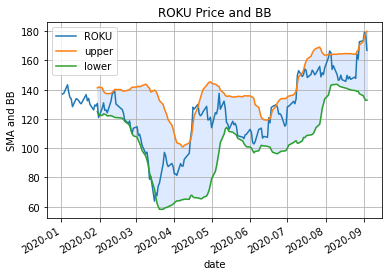

In [132]:
roku = yf.Ticker("ROKU")
df = roku.history(start="2020-01-01", end='2020-09-04')
df = df.loc[:,['Close']]
# rename the column header with symbol name
symbol = 'ROKU'
df = df.rename(columns={'Close': symbol})

# calculate Simple Moving Average with 20 days window
sma = df.rolling(window=20).mean()
# calculate the standard deviation
std = df.rolling(window=20).std()

upper_band = sma + 2 * std
upper_band = upper_band.rename(columns={symbol: 'upper'})
lower_band = sma - 2 * std
lower_band = lower_band.rename(columns={symbol: 'lower'})

df = df.join(upper_band).join(lower_band)
ax = df.plot(title='{} Price and BB'.format(symbol))
ax.fill_between(df.index, lower_band['lower'], upper_band['upper'], color='#ADCCFF', alpha=0.4)
ax.set_xlabel('date')
ax.set_ylabel('SMA and BB')
ax.grid()
plt.show()

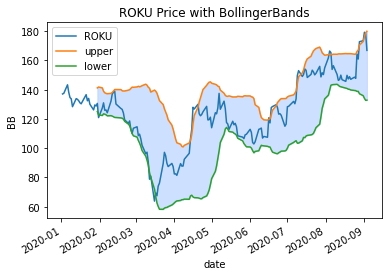

In [144]:
roku = yf.Ticker("ROKU")
df = roku.history(start="2020-01-01", end='2020-09-04')
df = df.loc[:,['Close']]
# rename the column header with symbol name
symbol = 'ROKU'
df = df.rename(columns={'Close': symbol})

# calculate Simple Moving Average with 20 days window
sma = df.rolling(window=20).mean()
# calculate the standard deviation
std = df.rolling(window=20).std()

upper_band = sma + 2 * std
upper_band = upper_band.rename(columns={symbol: 'upper'})
lower_band = sma - 2 * std
lower_band = lower_band.rename(columns={symbol: 'lower'})

df = df.join(upper_band).join(lower_band)
ax = df.plot(title='{} Price with BollingerBands'.format(symbol))
ax.fill_between(df.index, lower_band['lower'], upper_band['upper'], color='#ADCCFF', alpha=0.6)
ax.grid()
ax.set_xlabel('date')
ax.set_ylabel('BB')
plt.show()

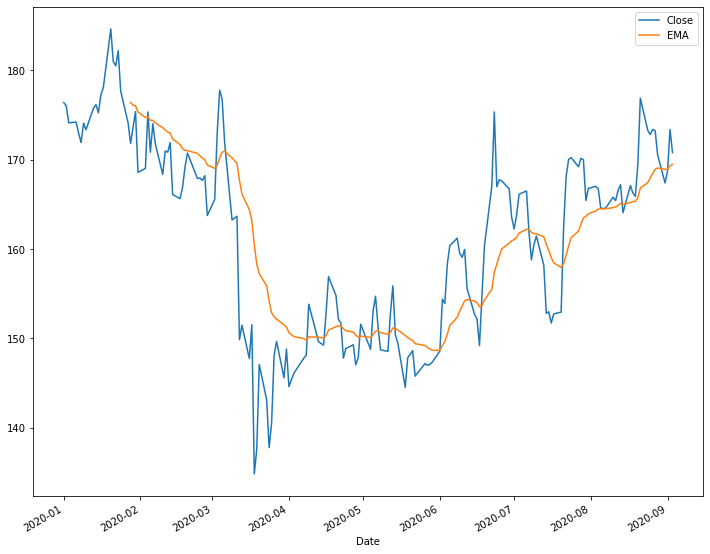

In [72]:
df['EMA'] = ta.EMA(df['Close'], timeperiod = 20)
df[['Close','EMA']].plot(figsize=(12,10))
plt.show()